In [1]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

import sys
import os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from include_columns import include_columns_corr_ml

dataset = "games_2018-present"
db = sqlite3.connect(f"/Users/aidenflynn/ML_Python/python-nfl/Data/v2.sqlite")
df = pd.read_sql_query(f"select * from \"{dataset}\"", db, index_col="index")

# fill scrm RELATED column Null with 0.0
df['AWAY_PASS_YDSSCRM_MAX'] = df['AWAY_PASS_YDSSCRM_MAX'].fillna(0.0)
df['AWAY_PASS_YDSSCRM_MEAN'] = df['AWAY_PASS_YDSSCRM_MEAN'].fillna(0.0)
df['AWAY_PASS_YDSSCRM_MIN'] = df['AWAY_PASS_YDSSCRM_MIN'].fillna(0.0)
df['AWAY_PASS_YDSSCRM_STD'] = df['AWAY_PASS_YDSSCRM_STD'].fillna(0.0)
df['HOME_PASS_YDSSCRM_MAX'] = df['HOME_PASS_YDSSCRM_MAX'].fillna(0.0)
df['HOME_PASS_YDSSCRM_MEAN'] = df['HOME_PASS_YDSSCRM_MEAN'].fillna(0.0)
df['HOME_PASS_YDSSCRM_MIN'] = df['HOME_PASS_YDSSCRM_MIN'].fillna(0.0)
df['HOME_PASS_YDSSCRM_STD'] = df['HOME_PASS_YDSSCRM_STD'].fillna(0.0)
# All other null values can be safely filled with -1: unavailable
df.fillna(-1, inplace=True) 
df.isnull().any(axis=1).sum()

df['HOME_PASS_PLAYOFF_WINPCT'] = np.where(
    (df['HOME_PASS_PLAYOFF_W'] + df['HOME_PASS_PLAYOFF_L']) > 0,
    df['HOME_PASS_PLAYOFF_W'] / (df['HOME_PASS_PLAYOFF_W'] + df['HOME_PASS_PLAYOFF_L']),
    -1
)
df['HOME_PASS_PLAYOFF_GAMES'] = df['HOME_PASS_PLAYOFF_W'] + df['HOME_PASS_PLAYOFF_L']

df['HOME_PASS_BIG_GAME_WINPCT'] = np.where(
    (df['HOME_PASS_BIG_GAME_W'] + df['HOME_PASS_BIG_GAME_L']) > 0,
    df['HOME_PASS_BIG_GAME_W'] / (df['HOME_PASS_BIG_GAME_W'] + df['HOME_PASS_BIG_GAME_L']),
    -1
)
df['HOME_PASS_BIG_GAMES'] = df['HOME_PASS_BIG_GAME_W'] + df['HOME_PASS_BIG_GAME_L']

# target home team win; drop dud and standard columns
TARGET = df['Home-Team-Win']
df = df.drop(
    [
        'ROOF', 'SURFACE', 'TEMP', 'WIND_SPEED', 'SPREAD_COVER', 'SPREAD', 'OU_COVER', 'OU', 'SCORE', 'Home-Team-Win', 'HOME_SCORE', 
        'AWAY_SCORE', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME', 'SEASON', 'AWAY_PASS_PLAYOFF_L', 'HOME_PASS_PLAYOFF_W', 'HOME_PASS_PLAYOFF_L',
        'AWAY_PASS_PLAYOFF_W','AWAY_PASS_BIG_GAME_W', 'AWAY_PASS_BIG_GAME_L', 'HOME_PASS_BIG_GAME_W', 'HOME_PASS_BIG_GAME_L'
    ], 
    axis=1
)

# split data for training
x_train, x_test, y_train, y_test = train_test_split(df, TARGET, test_size=.3)

In [2]:
# Example: Remove constant features
selector = VarianceThreshold(threshold=0.0)
X_reduced = selector.fit_transform(x_train)

X_reduced = pd.DataFrame(X_reduced, columns=x_train.columns[selector.get_support()])
X_reduced = X_reduced.loc[:, ~X_reduced.T.duplicated()]

corr_matrix = X_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_reduced = X_reduced.drop(columns=to_drop)

model = RandomForestClassifier()
model.fit(X_reduced, y_train)

# Get feature importance
importances = model.feature_importances_
importance_df = pd.DataFrame({'feature': X_reduced.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Select top 250 features
top_features = importance_df['feature'].head(250).tolist()
X_selected = X_reduced[top_features] # new X_train
X_test_selected = x_test[top_features] # new X_test 

In [10]:
def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

In [11]:
random_state = 42
def run_xgb_classifier(X_train, y_train, 
                                max_depth = 3,         
                                min_child_weight = 1,    
                                subsample = 1.0,
                                colsample_bytree = 1.0,    
                                gamma = 0, 
                                learning_rate = .1,     
                                n_estimators = 100,             
                                random_state = random_state,
                                cv=5,
                                n_jobs=-1
                               ):
    
    xgb_model = xgb.XGBClassifier(
        max_depth = max_depth,         
        min_child_weight = min_child_weight,       
        objective = 'binary:logistic',    
        subsample = subsample,
        colsample_bytree = colsample_bytree,    
        gamma = gamma, 
        learning_rate = learning_rate,     
        n_estimators = n_estimators,     
        n_jobs = n_jobs,              # use all possible cores
        random_state = random_state,
    )
    
    scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=n_jobs)

    mean_acc = np.mean(scores)  # Convert to positive MSE
    return mean_acc

In [12]:
run_xgb_classifier(X_selected, y_train, 
                                max_depth = 3,         
                                min_child_weight = 1,    
                                subsample = 1.0,
                                colsample_bytree = 1.0,    
                                gamma = 0, 
                                learning_rate = .1,     
                                n_estimators = 100,
                               )

/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/a

0.6232526589971782

  0%|          | 0/20 [00:00<?, ?it/s]/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

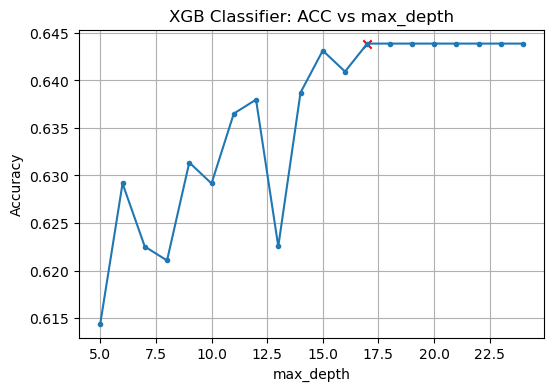

Max Accuracy 0.6439 found at x = 17
Execution Time: 50.11s


In [13]:
# Plot a n_estimators vs ACC using a simple for loop
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# record beginning time
start = time.time()

param = 'max_depth'  

# parameter_list = range(400,1000,50) 
parameter_list = range(5,25)      

accs = []

for n in tqdm(parameter_list):
    accs.append( run_xgb_classifier(X_selected, y_train, 
                                max_depth = n,         
                                min_child_weight = 1,    
                                subsample = 1.0,
                                colsample_bytree = 1.0,    
                                gamma = 0, 
                                learning_rate = .1,     
                                n_estimators = 100,
                            )
                ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("XGB Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

  0%|          | 0/50 [00:00<?, ?it/s]/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

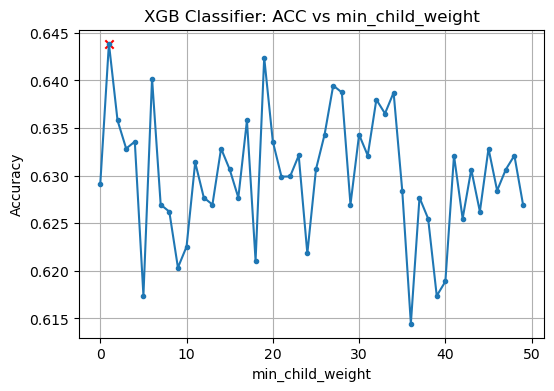

Max Accuracy 0.6439 found at x = 1
Execution Time: 47.82s


In [14]:
# record beginning time
start = time.time()

param = 'min_child_weight'  

# parameter_list = range(400,1000,50) 
parameter_list = range(0,50)      

accs = []

for n in tqdm(parameter_list):
    accs.append( run_xgb_classifier(X_selected, y_train, 
                                max_depth = 17,         
                                min_child_weight = n,    
                                subsample = 1.0,
                                colsample_bytree = 1.0,    
                                gamma = 0, 
                                learning_rate = .1,     
                                n_estimators = 100,
                            )
                ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("XGB Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

  0%|          | 0/11 [00:00<?, ?it/s]/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

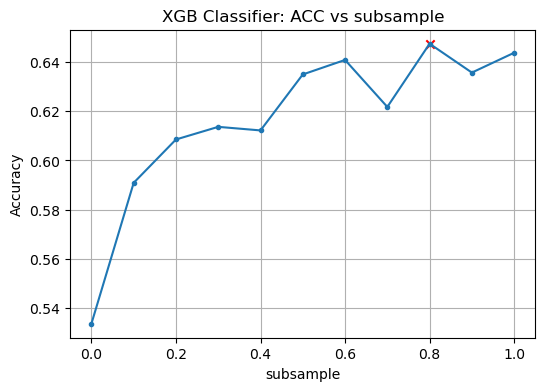

Max Accuracy 0.6475 found at x = 0.8000
Execution Time: 19.60s


In [16]:
# record beginning time
start = time.time()

param = 'subsample'  

parameter_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

accs = []

for n in tqdm(parameter_list):
    accs.append( run_xgb_classifier(X_selected, y_train, 
                                max_depth = 17,         
                                min_child_weight = 1,    
                                subsample = n,
                                colsample_bytree = 1.0,    
                                gamma = 0, 
                                learning_rate = .1,     
                                n_estimators = 100,
                            )
                ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("XGB Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

  0%|          | 0/11 [00:00<?, ?it/s]/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

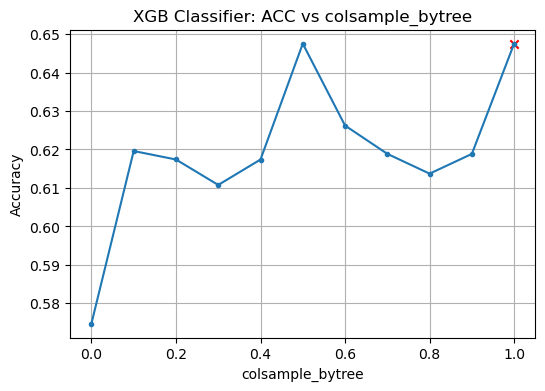

Max Accuracy 0.6475 found at x = 1
Execution Time: 19.59s


In [17]:
# record beginning time
start = time.time()

param = 'colsample_bytree'  

parameter_list = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]    

accs = []

for n in tqdm(parameter_list):
    accs.append( run_xgb_classifier(X_selected, y_train, 
                                max_depth = 17,         
                                min_child_weight = 1,    
                                subsample = .8,
                                colsample_bytree = n,    
                                gamma = 0, 
                                learning_rate = .1,     
                                n_estimators = 100,
                            )
                ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("XGB Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

  0%|          | 0/25 [00:00<?, ?it/s]/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

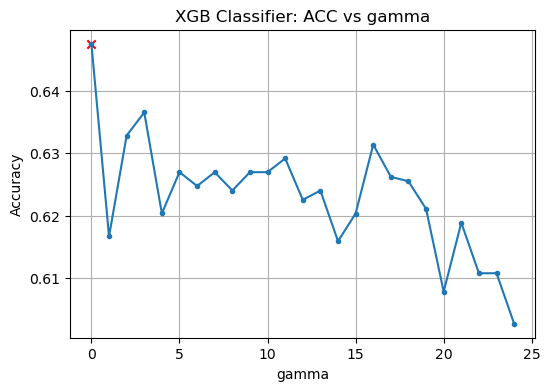

Max Accuracy 0.6475 found at x = 0
Execution Time: 15.19s


In [18]:
# record beginning time
start = time.time()

param = 'gamma'  

parameter_list = range(0,25)    

accs = []

for n in tqdm(parameter_list):
    accs.append( run_xgb_classifier(X_selected, y_train, 
                                max_depth = 17,         
                                min_child_weight = 1,    
                                subsample = .8,
                                colsample_bytree = 1.0,    
                                gamma = n, 
                                learning_rate = .1,     
                                n_estimators = 100,
                            )
                ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("XGB Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

  0%|          | 0/20 [00:00<?, ?it/s]/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

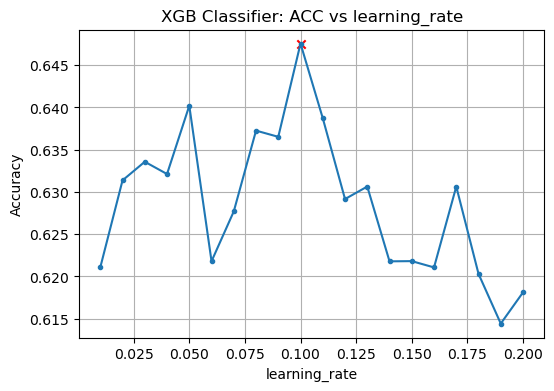

Max Accuracy 0.6475 found at x = 0.1000
Execution Time: 53.14s


In [21]:
# record beginning time
start = time.time()

param = 'learning_rate'  

parameter_list = [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1,.11,.12,.13,.14,.15,.16,.17,.18,.19,.2]    

accs = []

for n in tqdm(parameter_list):
    accs.append( run_xgb_classifier(X_selected, y_train, 
                                max_depth = 17,         
                                min_child_weight = 1,    
                                subsample = .8,
                                colsample_bytree = 1.0,    
                                gamma = 0, 
                                learning_rate = n,     
                                n_estimators = 100,
                            )
                ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("XGB Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

  0%|          | 0/19 [00:00<?, ?it/s]/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

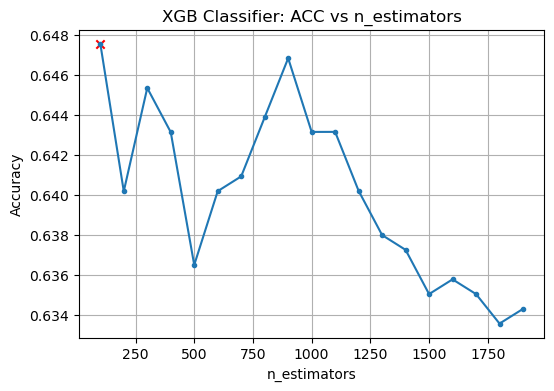

Max Accuracy 0.6475 found at x = 100
Execution Time: 1m 36.68s


In [23]:
# record beginning time
start = time.time()

param = 'n_estimators'  

parameter_list = range(100,2000,100) 

accs = []

for n in tqdm(parameter_list):
    accs.append( run_xgb_classifier(X_selected, y_train, 
                                max_depth = 17,         
                                min_child_weight = 1,    
                                subsample = .8,
                                colsample_bytree = 1.0,    
                                gamma = 0, 
                                learning_rate = .1,     
                                n_estimators = n,
                            )
                ) 


                            
# Find the max value
max_acc = max(accs)

# Find the index of the minimum value
max_index = accs.index(max_acc)

plt.figure(figsize=(6, 4))
plt.title("XGB Classifier: ACC vs "+param)
plt.plot(parameter_list, accs, marker='.')
plt.scatter([parameter_list[max_index]],[max_acc],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("Accuracy")
plt.grid()
plt.show()

if isinstance(parameter_list[max_index], int):
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]}")
else:
    print(f"Max Accuracy {max_acc:.4f} found at x = {parameter_list[max_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

In [24]:
run_xgb_classifier(X_selected, y_train, 
                                max_depth = 17,         
                                min_child_weight = 1,    
                                subsample = .8,
                                colsample_bytree = 1.0,    
                                gamma = 0, 
                                learning_rate = .1,     
                                n_estimators = 100,
                            )

/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/aidenflynn/anaconda3/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or i

0.6475472107662253